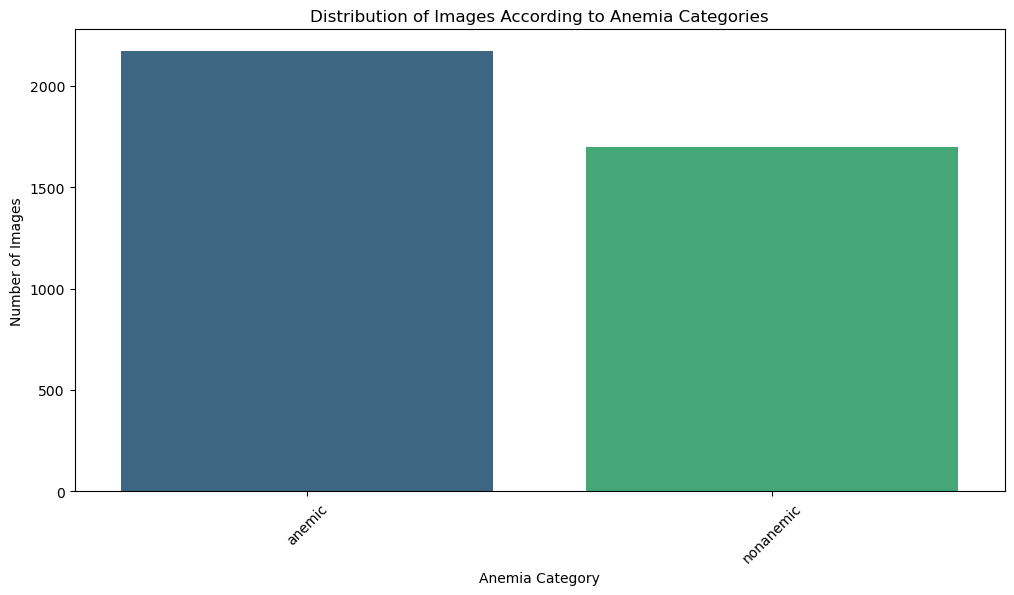

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to your data directory
data_dir = "Palm"

# Get the list of waste categories
categories = os.listdir(data_dir)

# Create a dictionary to store the count of images for each category
category_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}

# Convert the dictionary to a pandas DataFrame for easier manipulation
df_counts = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])

# Plot the distribution of images across categories
plt.figure(figsize=(12, 6))
sns.barplot(x=df_counts.index, y=df_counts['Count'], palette='viridis')
plt.title('Distribution of Images According to Anemia Categories')
plt.xlabel('Anemia Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()



In [2]:
import os
import pandas as pd

# Create lists to store file paths and corresponding target labels
file_paths = []
targets = []

# Iterate through each waste category
for category in categories:
    category_dir = os.path.join(data_dir, category)
    
    # Iterate through each image file in the category directory
    for img_file in os.listdir(category_dir):
        # Construct the file path
        img_path = os.path.join(category_dir, img_file)
        
        # Append the file path and target label to the lists
        file_paths.append(img_path)
        targets.append(category)

# Create a DataFrame from the lists
df = pd.DataFrame({'File_Path': file_paths, 'Target': targets})

In [3]:
df

,File_Path,Target
0,Palm\anemic\Anemic-260 (10).png,anemic
1,Palm\anemic\Anemic-260 (12).png,anemic
2,Palm\anemic\Anemic-260 (2).png,anemic
3,Palm\anemic\Anemic-260 (4).png,anemic
4,Palm\anemic\Anemic-260 (6).png,anemic
...,...,...
3862,Palm\nonanemic\Non-AnemicP-204 (6).png,nonanemic
3863,Palm\nonanemic\Non-AnemicP-204 (7).png,nonanemic
3864,Palm\nonanemic\Non-AnemicP-204 (8).png,nonanemic
3865,Palm\nonanemic\Non-AnemicP-204 (9).png,nonanemic


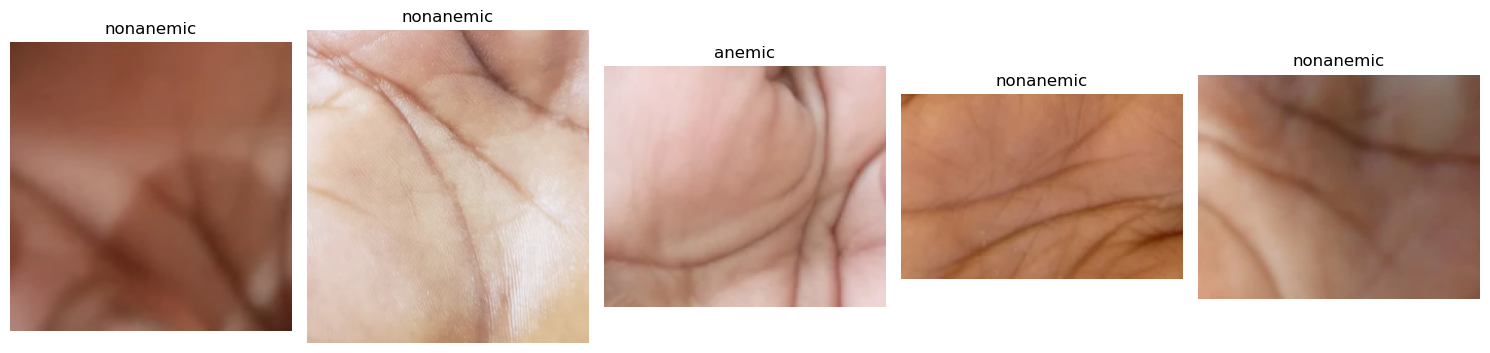

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Choose the number of random photos to display
num_photos = 5

# Create a figure to display the photos
plt.figure(figsize=(15, 5))

# Iterate through the number of photos to display
for i in range(num_photos):
    # Choose a random waste category
    random_category = random.choice(categories)
    category_dir = os.path.join(data_dir, random_category)
    
    # Choose a random image file from the category directory
    random_img_file = random.choice(os.listdir(category_dir))
    img_path = os.path.join(category_dir, random_img_file)
    
    # Read and display the image
    img = mpimg.imread(img_path)
    plt.subplot(1, num_photos, i+1)
    plt.imshow(img)
    plt.title(random_category)
    plt.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(3093, 387, 387)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 3093 validated image filenames belonging to 2 classes.


In [8]:
# Create validation data generator
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 387 validated image filenames belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 387 validated image filenames belonging to 2 classes.


# MobileNetV2

# Batch Size = 18

Epochs = 15

In [60]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
172/172 [==============================] - 85s 479ms/step - loss: 0.7765 - accuracy: 0.6958 - val_loss: 0.5091 - val_accuracy: 0.7571
Epoch 2/15
172/172 [==============================] - 82s 476ms/step - loss: 0.3170 - accuracy: 0.8658 - val_loss: 0.3002 - val_accuracy: 0.8863
Epoch 3/15
172/172 [==============================] - 80s 462ms/step - loss: 0.1791 - accuracy: 0.9370 - val_loss: 0.2560 - val_accuracy: 0.8966
Epoch 4/15
172/172 [==============================] - 78s 454ms/step - loss: 0.1359 - accuracy: 0.9483 - val_loss: 0.2002 - val_accuracy: 0.9354
Epoch 5/15
172/172 [==============================] - 83s 481ms/step - loss: 0.0970 - accuracy: 0.9641 - val_loss: 0.2433 - val_accuracy: 0.9096
Epoch 6/15
172/172 [==============================] - 80s 464ms/step - loss: 0.0986 - accuracy: 0.9661 - val_loss: 0.2208 - val_accuracy: 0.9225
Epoch 7/15
172/172 [==============================] - 78s 453ms/step - loss: 0.0695 - accuracy: 0.9728 - val_loss: 0.2899 - val_ac

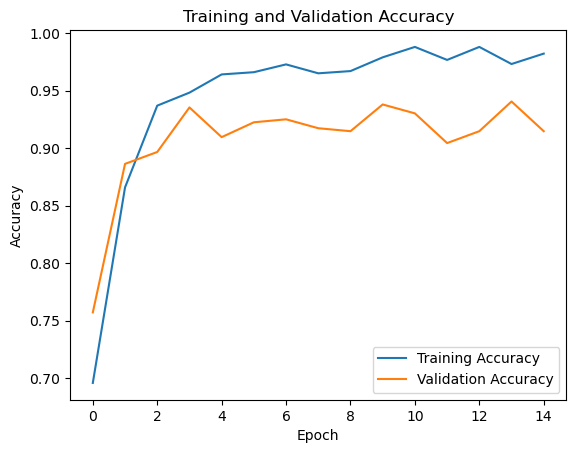

In [61]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 166ms/step
Accuracy: 0.9250645994832042
AUC: 0.9622376311844079
Precision: 0.9378531073446328
Recall: 0.9021739130434783
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                0
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                0
4            Palm\anemic\AnemicP-083 (12).png           0                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           0                0
386         

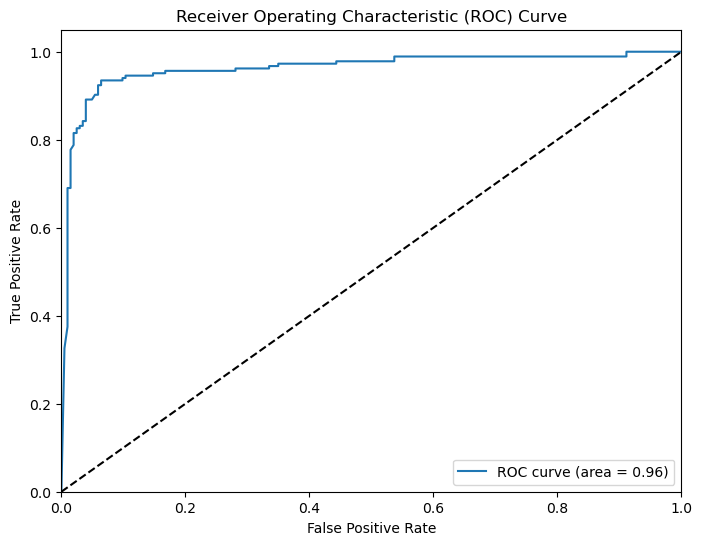

In [63]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


Epochs = 25

In [64]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
172/172 [==============================] - 82s 465ms/step - loss: 0.9007 - accuracy: 0.6922 - val_loss: 0.3955 - val_accuracy: 0.8501
Epoch 2/25
172/172 [==============================] - 80s 464ms/step - loss: 0.2856 - accuracy: 0.8923 - val_loss: 0.2730 - val_accuracy: 0.8915
Epoch 3/25
172/172 [==============================] - 78s 454ms/step - loss: 0.1970 - accuracy: 0.9227 - val_loss: 0.2349 - val_accuracy: 0.9018
Epoch 4/25
172/172 [==============================] - 78s 453ms/step - loss: 0.1145 - accuracy: 0.9606 - val_loss: 0.2492 - val_accuracy: 0.8837
Epoch 5/25
172/172 [==============================] - 78s 451ms/step - loss: 0.1131 - accuracy: 0.9589 - val_loss: 0.2314 - val_accuracy: 0.9199
Epoch 6/25
172/172 [==============================] - 78s 451ms/step - loss: 0.0949 - accuracy: 0.9644 - val_loss: 0.2477 - val_accuracy: 0.9173
Epoch 7/25
172/172 [==============================] - 78s 451ms/step - loss: 0.0726 - accuracy: 0.9722 - val_loss: 0.2539 - val_ac

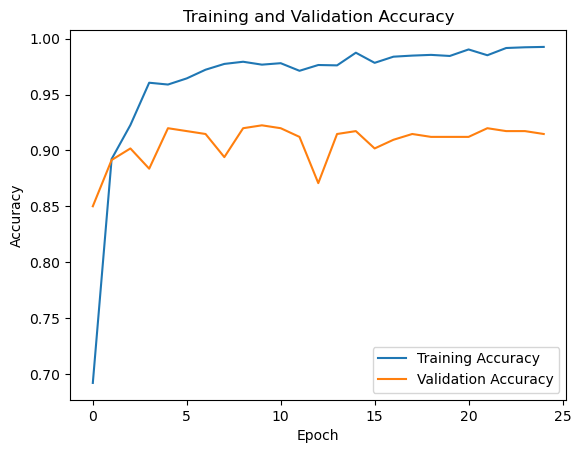

In [65]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 154ms/step
Accuracy: 0.9250645994832042
AUC: 0.9640179910044977
Precision: 0.9329608938547486
Recall: 0.907608695652174
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                0
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                0
4            Palm\anemic\AnemicP-083 (12).png           0                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           0                0
386          

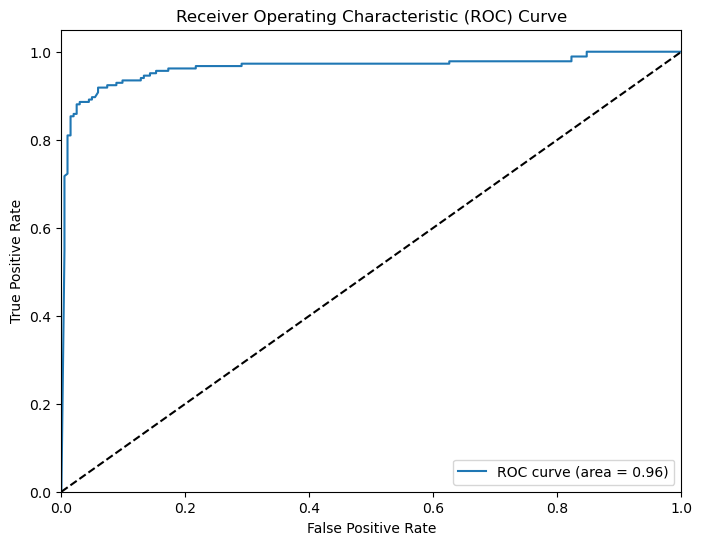

In [66]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [147]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 80s 802ms/step - loss: 0.9973 - accuracy: 0.6621 - val_loss: 0.4705 - val_accuracy: 0.7778
Epoch 2/15
97/97 [==============================] - 72s 740ms/step - loss: 0.3616 - accuracy: 0.8603 - val_loss: 0.3407 - val_accuracy: 0.8786
Epoch 3/15
97/97 [==============================] - 69s 711ms/step - loss: 0.2144 - accuracy: 0.9208 - val_loss: 0.2602 - val_accuracy: 0.8992
Epoch 4/15
97/97 [==============================] - 71s 735ms/step - loss: 0.1151 - accuracy: 0.9644 - val_loss: 0.1945 - val_accuracy: 0.9328
Epoch 5/15
97/97 [==============================] - 69s 714ms/step - loss: 0.0682 - accuracy: 0.9825 - val_loss: 0.2270 - val_accuracy: 0.9147
Epoch 6/15
97/97 [==============================] - 71s 730ms/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 0.1979 - val_accuracy: 0.9302
Epoch 7/15
97/97 [==============================] - 73s 749ms/step - loss: 0.0397 - accuracy: 0.9909 - val_loss: 0.3097 - val_accuracy: 0.9018

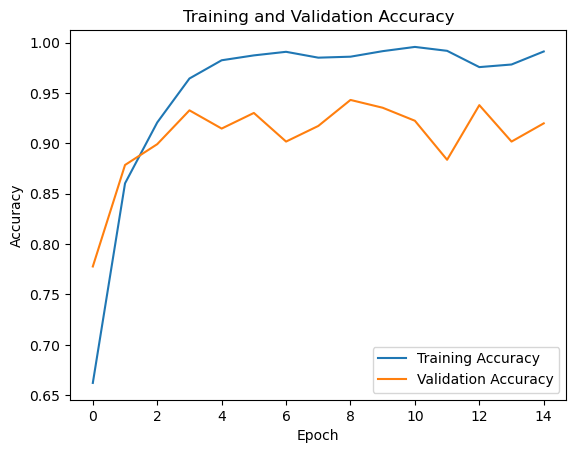

In [149]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 979ms/step
Accuracy: 0.9354005167958657
AUC: 0.9703898050974513
Precision: 0.9392265193370166
Recall: 0.9239130434782609
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386         

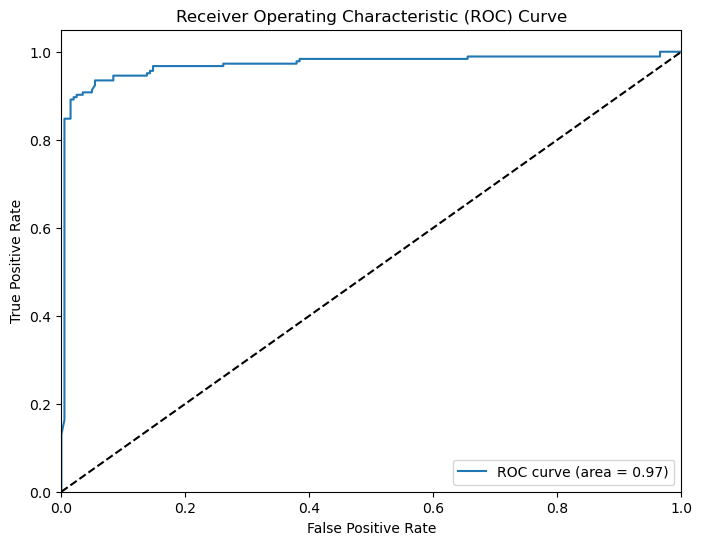

In [150]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [151]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
97/97 [==============================] - 77s 764ms/step - loss: 1.2743 - accuracy: 0.5529 - val_loss: 0.5825 - val_accuracy: 0.5969
Epoch 2/25
97/97 [==============================] - 70s 717ms/step - loss: 0.5500 - accuracy: 0.7174 - val_loss: 0.5486 - val_accuracy: 0.7649
Epoch 3/25
97/97 [==============================] - 69s 712ms/step - loss: 0.4067 - accuracy: 0.8299 - val_loss: 0.3403 - val_accuracy: 0.8527
Epoch 4/25
97/97 [==============================] - 70s 716ms/step - loss: 0.2304 - accuracy: 0.9179 - val_loss: 0.3360 - val_accuracy: 0.8527
Epoch 5/25
97/97 [==============================] - 69s 714ms/step - loss: 0.1465 - accuracy: 0.9473 - val_loss: 0.2628 - val_accuracy: 0.8941
Epoch 6/25
97/97 [==============================] - 69s 712ms/step - loss: 0.1174 - accuracy: 0.9551 - val_loss: 0.2713 - val_accuracy: 0.8966
Epoch 7/25
97/97 [==============================] - 69s 711ms/step - loss: 0.0758 - accuracy: 0.9764 - val_loss: 0.3492 - val_accuracy: 0.8811

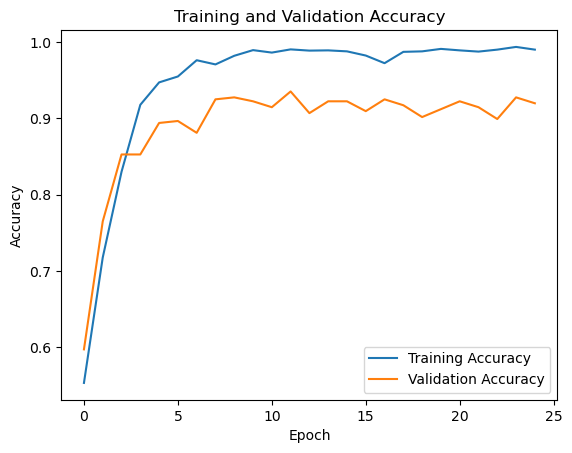

In [152]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy: 0.9198966408268734
AUC: 0.9612604412079675
Precision: 0.9135135135135135
Recall: 0.9184782608695652
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386            

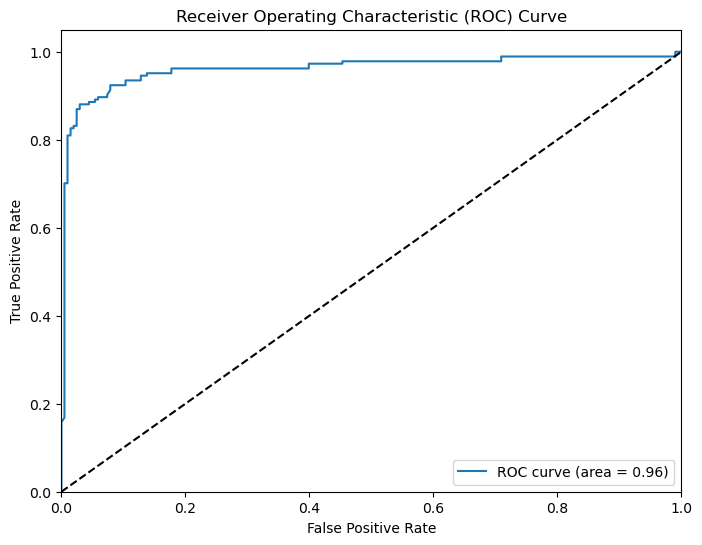

In [153]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [27]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 77s 754ms/step - loss: 0.8916 - accuracy: 0.6195 - val_loss: 0.5637 - val_accuracy: 0.6899
Epoch 2/15
97/97 [==============================] - 73s 747ms/step - loss: 0.4800 - accuracy: 0.7336 - val_loss: 0.3709 - val_accuracy: 0.8010
Epoch 3/15
97/97 [==============================] - 71s 731ms/step - loss: 0.2886 - accuracy: 0.8694 - val_loss: 0.3169 - val_accuracy: 0.8889
Epoch 4/15
97/97 [==============================] - 74s 759ms/step - loss: 0.1916 - accuracy: 0.9350 - val_loss: 0.2279 - val_accuracy: 0.9173
Epoch 5/15
97/97 [==============================] - 75s 767ms/step - loss: 0.1368 - accuracy: 0.9564 - val_loss: 0.2434 - val_accuracy: 0.9173
Epoch 6/15
97/97 [==============================] - 72s 740ms/step - loss: 0.0921 - accuracy: 0.9761 - val_loss: 0.2136 - val_accuracy: 0.9070
Epoch 7/15
97/97 [==============================] - 73s 749ms/step - loss: 0.0626 - accuracy: 0.9822 - val_loss: 0.2196 - val_accuracy: 0.9173

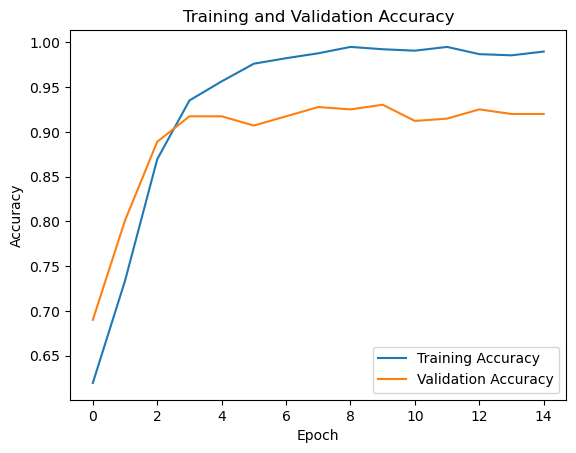

In [28]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9198966408268734
AUC: 0.9597611908331549
Precision: 0.9090909090909091
Recall: 0.9239130434782609
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                0
386            

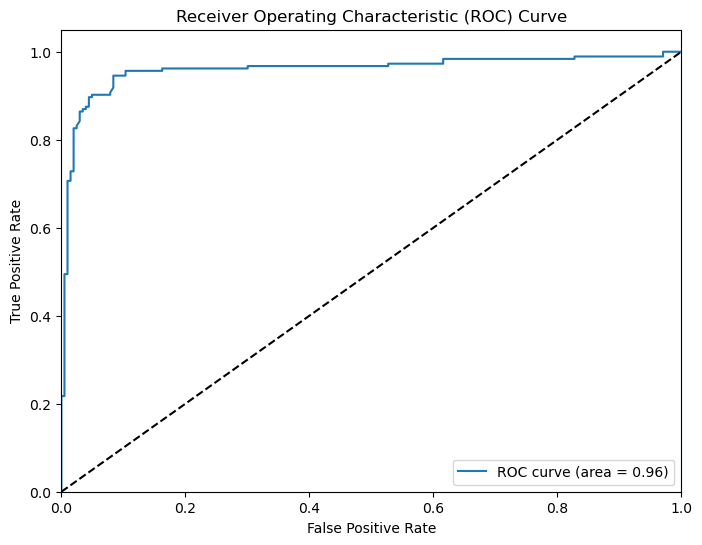

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [30]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
97/97 [==============================] - 81s 772ms/step - loss: 0.9978 - accuracy: 0.6243 - val_loss: 0.5024 - val_accuracy: 0.7519
Epoch 2/25
97/97 [==============================] - 69s 712ms/step - loss: 0.4322 - accuracy: 0.7999 - val_loss: 0.3676 - val_accuracy: 0.8630
Epoch 3/25
97/97 [==============================] - 69s 714ms/step - loss: 0.2759 - accuracy: 0.8846 - val_loss: 0.3314 - val_accuracy: 0.8630
Epoch 4/25
97/97 [==============================] - 69s 716ms/step - loss: 0.1445 - accuracy: 0.9463 - val_loss: 0.2447 - val_accuracy: 0.8915
Epoch 5/25
97/97 [==============================] - 70s 724ms/step - loss: 0.1057 - accuracy: 0.9638 - val_loss: 0.2487 - val_accuracy: 0.9096
Epoch 6/25
97/97 [==============================] - 69s 713ms/step - loss: 0.0844 - accuracy: 0.9738 - val_loss: 0.1947 - val_accuracy: 0.9276
Epoch 7/25
97/97 [==============================] - 70s 725ms/step - loss: 0.0639 - accuracy: 0.9842 - val_loss: 0.2136 - val_accuracy: 0.9225

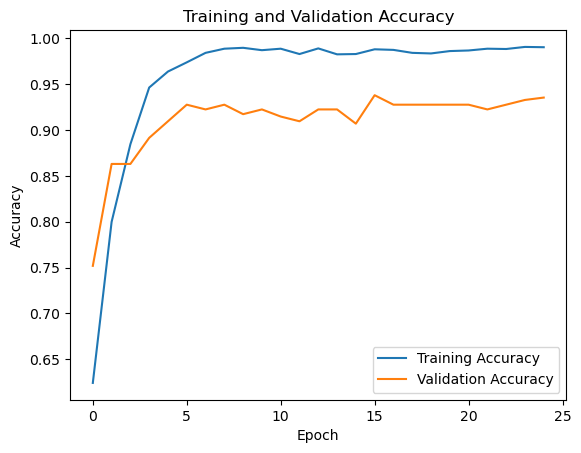

In [31]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9121447028423773
AUC: 0.9580209895052473
Precision: 0.9120879120879121
Recall: 0.9021739130434783
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386            

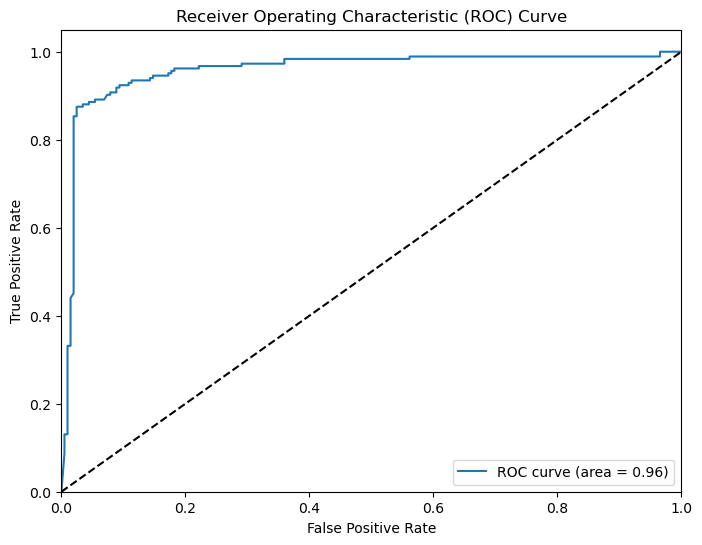

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [33]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 76s 755ms/step - loss: 0.8840 - accuracy: 0.6815 - val_loss: 0.4574 - val_accuracy: 0.8062
Epoch 2/15
97/97 [==============================] - 70s 719ms/step - loss: 0.3104 - accuracy: 0.8833 - val_loss: 0.3069 - val_accuracy: 0.8760
Epoch 3/15
97/97 [==============================] - 70s 719ms/step - loss: 0.1861 - accuracy: 0.9376 - val_loss: 0.2488 - val_accuracy: 0.9044
Epoch 4/15
97/97 [==============================] - 70s 723ms/step - loss: 0.1132 - accuracy: 0.9680 - val_loss: 0.2011 - val_accuracy: 0.9328
Epoch 5/15
97/97 [==============================] - 73s 747ms/step - loss: 0.0718 - accuracy: 0.9790 - val_loss: 0.2123 - val_accuracy: 0.9251
Epoch 6/15
97/97 [==============================] - 72s 739ms/step - loss: 0.0536 - accuracy: 0.9871 - val_loss: 0.2174 - val_accuracy: 0.9251
Epoch 7/15
97/97 [==============================] - 76s 779ms/step - loss: 0.0482 - accuracy: 0.9867 - val_loss: 0.2158 - val_accuracy: 0.9225

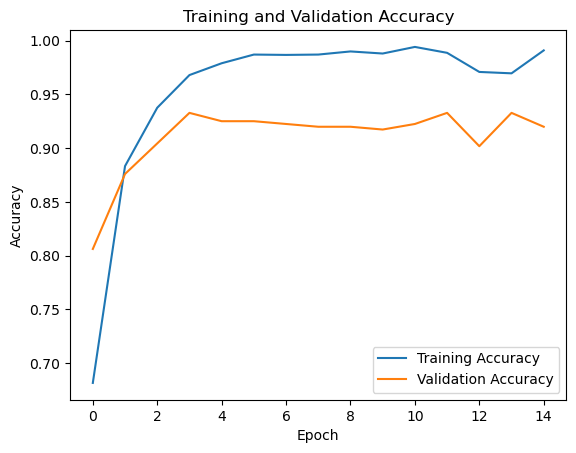

In [34]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.9121447028423773
AUC: 0.9575524737631185
Precision: 0.907608695652174
Recall: 0.907608695652174
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386              

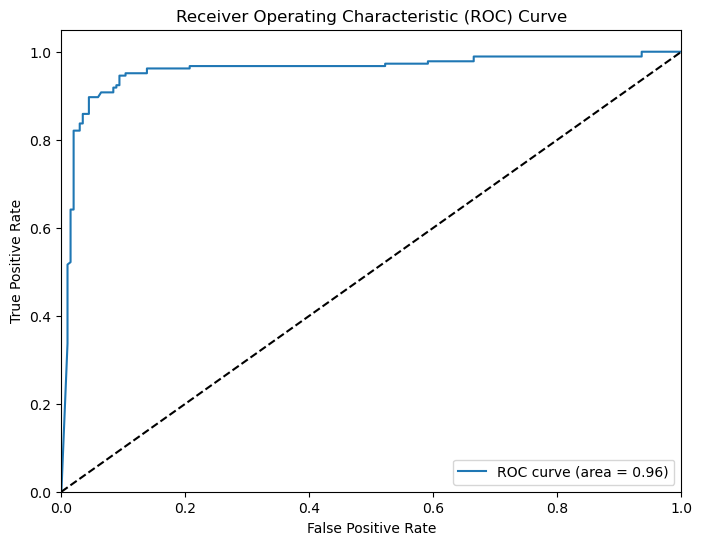

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [36]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Create and compile the MobileNetV2-based model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze the base model layers
base_model.trainable = False


# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
97/97 [==============================] - 73s 731ms/step - loss: 0.8813 - accuracy: 0.6634 - val_loss: 0.5157 - val_accuracy: 0.7416
Epoch 2/25
97/97 [==============================] - 70s 719ms/step - loss: 0.4091 - accuracy: 0.8442 - val_loss: 0.3641 - val_accuracy: 0.8605
Epoch 3/25
97/97 [==============================] - 70s 726ms/step - loss: 0.2173 - accuracy: 0.9324 - val_loss: 0.2384 - val_accuracy: 0.9199
Epoch 4/25
97/97 [==============================] - 72s 739ms/step - loss: 0.1149 - accuracy: 0.9683 - val_loss: 0.2521 - val_accuracy: 0.9147
Epoch 5/25
97/97 [==============================] - 70s 725ms/step - loss: 0.0712 - accuracy: 0.9832 - val_loss: 0.2231 - val_accuracy: 0.9225
Epoch 6/25
97/97 [==============================] - 70s 723ms/step - loss: 0.0401 - accuracy: 0.9919 - val_loss: 0.2365 - val_accuracy: 0.9147
Epoch 7/25
97/97 [==============================] - 70s 719ms/step - loss: 0.0352 - accuracy: 0.9922 - val_loss: 0.2076 - val_accuracy: 0.9354

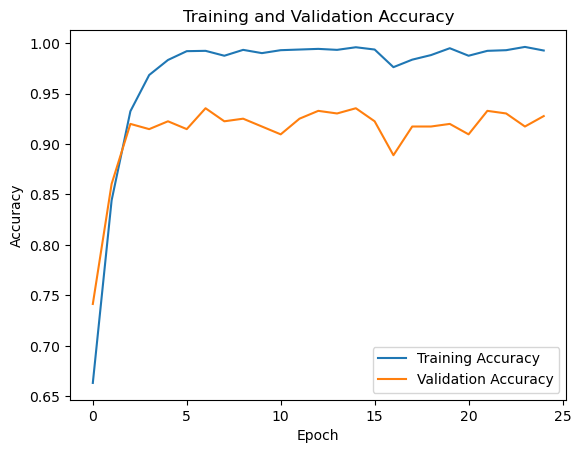

In [37]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 744ms/step
Accuracy: 0.9276485788113695
AUC: 0.9639376740201329
Precision: 0.9285714285714286
Recall: 0.9184782608695652
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386         

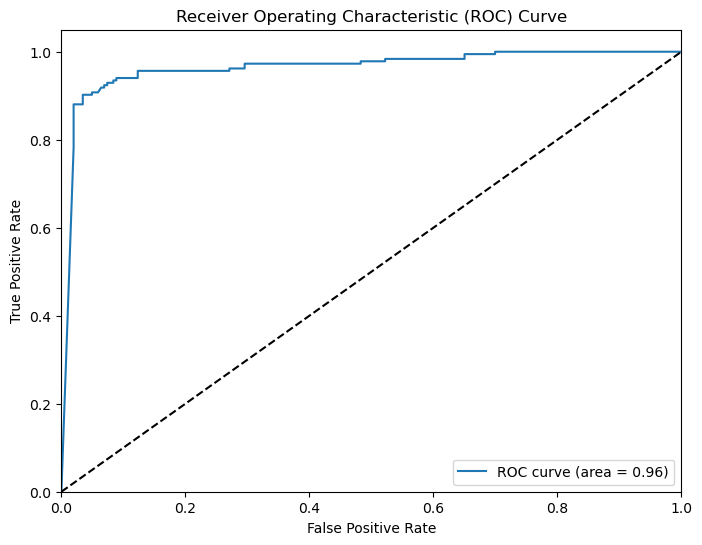

In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


# CNN

In [90]:
#batch size = 128
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
25/25 [==============================] - 151s 5s/step - loss: 0.6985 - accuracy: 0.5464 - val_loss: 0.6888 - val_accuracy: 0.5969
Epoch 2/15
25/25 [==============================] - 126s 5s/step - loss: 0.6873 - accuracy: 0.5561 - val_loss: 0.6923 - val_accuracy: 0.5943
Epoch 3/15
25/25 [==============================] - 121s 5s/step - loss: 0.6908 - accuracy: 0.5609 - val_loss: 0.6866 - val_accuracy: 0.5969
Epoch 4/15
25/25 [==============================] - 124s 5s/step - loss: 0.6896 - accuracy: 0.5609 - val_loss: 0.6836 - val_accuracy: 0.5969
Epoch 5/15
25/25 [==============================] - 122s 5s/step - loss: 0.6879 - accuracy: 0.5609 - val_loss: 0.6800 - val_accuracy: 0.5969
Epoch 6/15
25/25 [==============================] - 123s 5s/step - loss: 0.6857 - accuracy: 0.5609 - val_loss: 0.6757 - val_accuracy: 0.5969
Epoch 7/15
25/25 [==============================] - 122s 5s/step - loss: 0.6726 - accuracy: 0.5619 - val_loss: 0.6364 - val_accuracy: 0.6150
Epoch 8/15
25

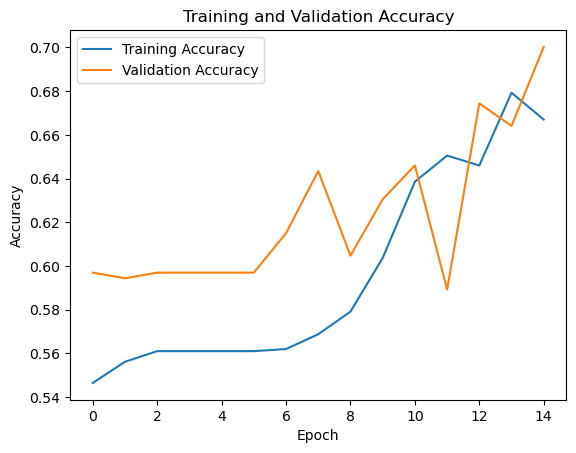

In [91]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 252ms/step
Accuracy: 0.5968992248062015
AUC: 0.7118226600985221
Precision: 0.6166666666666667
Recall: 0.40217391304347827
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                1
4            Palm\anemic\AnemicP-083 (12).png           1                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           0                1
386        

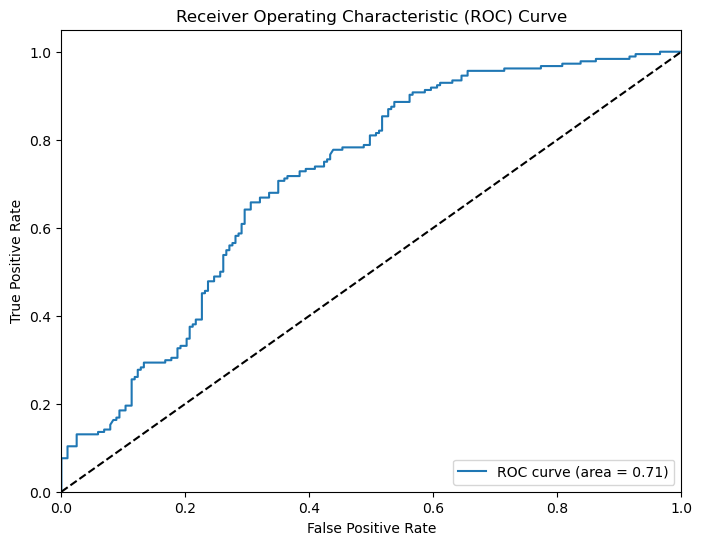

In [92]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [97]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 120s 1s/step - loss: 0.6834 - accuracy: 0.5496 - val_loss: 0.6626 - val_accuracy: 0.5969
Epoch 2/15
97/97 [==============================] - 126s 1s/step - loss: 0.6650 - accuracy: 0.5651 - val_loss: 0.6489 - val_accuracy: 0.6072
Epoch 3/15
97/97 [==============================] - 131s 1s/step - loss: 0.6649 - accuracy: 0.5778 - val_loss: 0.6722 - val_accuracy: 0.5995
Epoch 4/15
97/97 [==============================] - 115s 1s/step - loss: 0.6593 - accuracy: 0.5900 - val_loss: 0.6472 - val_accuracy: 0.6382
Epoch 5/15
97/97 [==============================] - 115s 1s/step - loss: 0.6633 - accuracy: 0.5868 - val_loss: 0.6389 - val_accuracy: 0.6072
Epoch 6/15
97/97 [==============================] - 114s 1s/step - loss: 0.6463 - accuracy: 0.6237 - val_loss: 0.6707 - val_accuracy: 0.5607
Epoch 7/15
97/97 [==============================] - 114s 1s/step - loss: 0.6265 - accuracy: 0.6495 - val_loss: 0.6006 - val_accuracy: 0.6848
Epoch 8/15
97

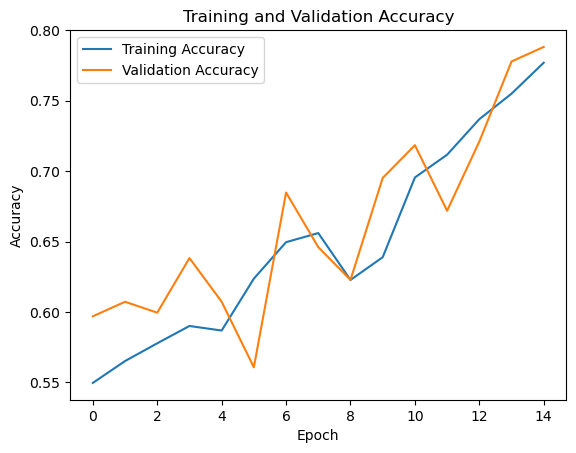

In [98]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 156ms/step
Accuracy: 0.7441860465116279
AUC: 0.8274523452559435
Precision: 0.7456647398843931
Recall: 0.7010869565217391
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                0
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386         

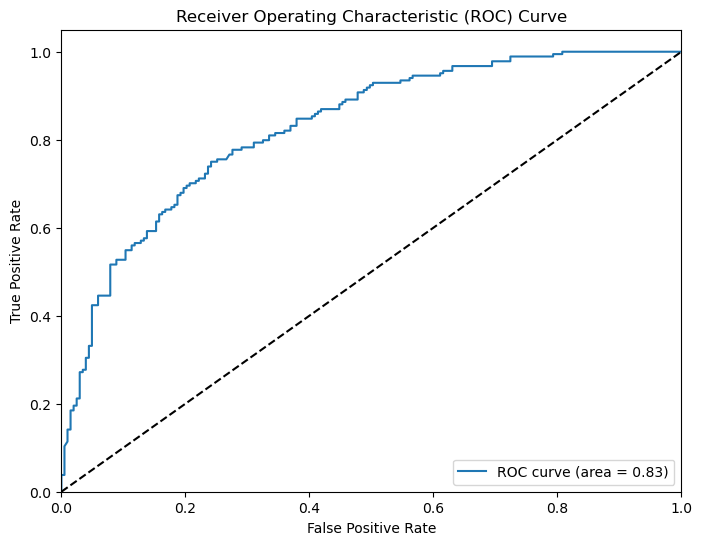

In [99]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [103]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/13
97/97 [==============================] - 148s 2s/step - loss: 0.6902 - accuracy: 0.5551 - val_loss: 0.6708 - val_accuracy: 0.5969
Epoch 2/13
97/97 [==============================] - 143s 1s/step - loss: 0.6705 - accuracy: 0.5716 - val_loss: 0.6569 - val_accuracy: 0.6072
Epoch 3/13
97/97 [==============================] - 133s 1s/step - loss: 0.6463 - accuracy: 0.6178 - val_loss: 0.6216 - val_accuracy: 0.6434
Epoch 4/13
97/97 [==============================] - 137s 1s/step - loss: 0.6415 - accuracy: 0.6204 - val_loss: 0.6064 - val_accuracy: 0.6615
Epoch 5/13
97/97 [==============================] - 132s 1s/step - loss: 0.6065 - accuracy: 0.6573 - val_loss: 0.5733 - val_accuracy: 0.7080
Epoch 6/13
97/97 [==============================] - 117s 1s/step - loss: 0.5990 - accuracy: 0.6638 - val_loss: 0.5823 - val_accuracy: 0.6796
Epoch 7/13
97/97 [==============================] - 116s 1s/step - loss: 0.5588 - accuracy: 0.7071 - val_loss: 0.5357 - val_accuracy: 0.7390
Epoch 8/13
97

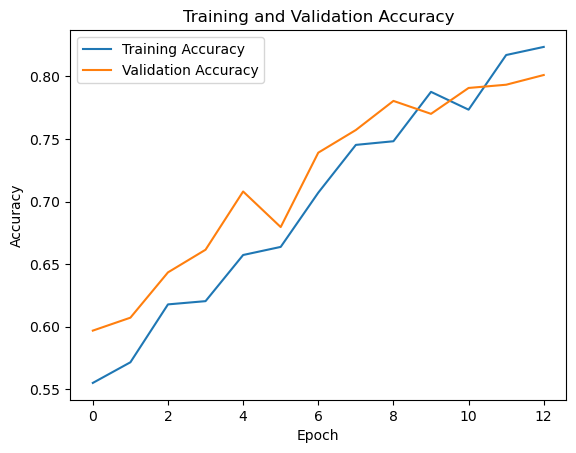

In [104]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 60ms/step
Accuracy: 0.772609819121447
AUC: 0.8709573784536304
Precision: 0.8037974683544303
Recall: 0.6902173913043478
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                0
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386           

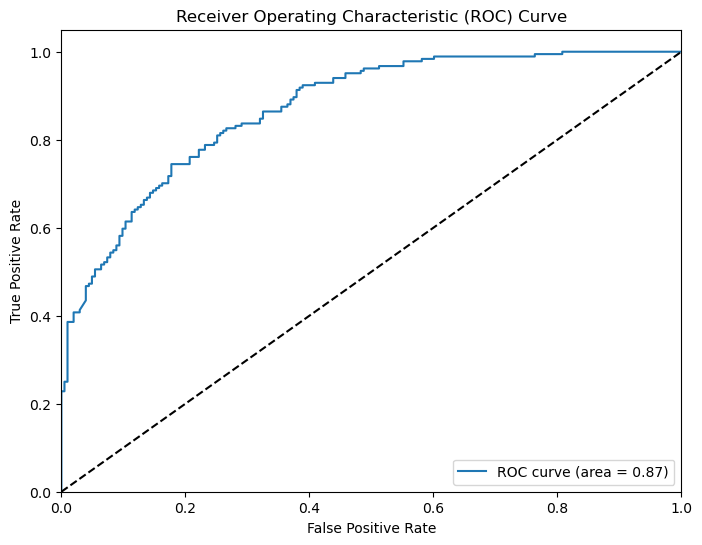

In [106]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [107]:
#batch size = 32
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
97/97 [==============================] - 114s 1s/step - loss: 0.6932 - accuracy: 0.5412 - val_loss: 0.6876 - val_accuracy: 0.5969
Epoch 2/10
97/97 [==============================] - 113s 1s/step - loss: 0.6894 - accuracy: 0.5609 - val_loss: 0.6781 - val_accuracy: 0.5969
Epoch 3/10
97/97 [==============================] - 114s 1s/step - loss: 0.6876 - accuracy: 0.5609 - val_loss: 0.6746 - val_accuracy: 0.5969
Epoch 4/10
97/97 [==============================] - 113s 1s/step - loss: 0.6788 - accuracy: 0.5609 - val_loss: 0.6602 - val_accuracy: 0.5969
Epoch 5/10
97/97 [==============================] - 112s 1s/step - loss: 0.6670 - accuracy: 0.5745 - val_loss: 0.6456 - val_accuracy: 0.6124
Epoch 6/10
97/97 [==============================] - 109s 1s/step - loss: 0.6751 - accuracy: 0.5732 - val_loss: 0.6481 - val_accuracy: 0.6227
Epoch 7/10
97/97 [==============================] - 110s 1s/step - loss: 0.6404 - accuracy: 0.6188 - val_loss: 0.6239 - val_accuracy: 0.6124
Epoch 8/10
97

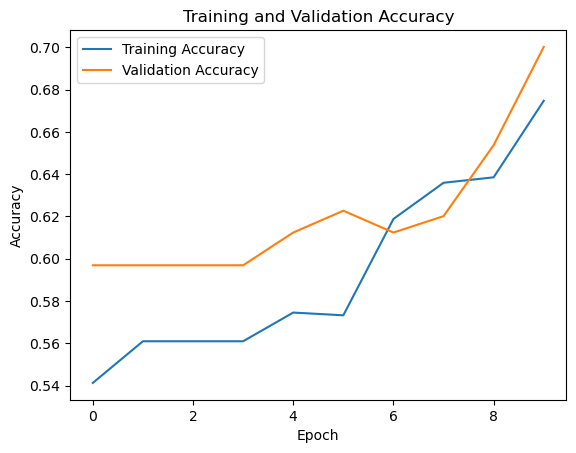

In [108]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 136ms/step
Accuracy: 0.648578811369509
AUC: 0.7222906403940886
Precision: 0.6714285714285714
Recall: 0.5108695652173914
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                0
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                0
383           Palm\anemic\AnemicP-041 (2).png           0                0
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386          

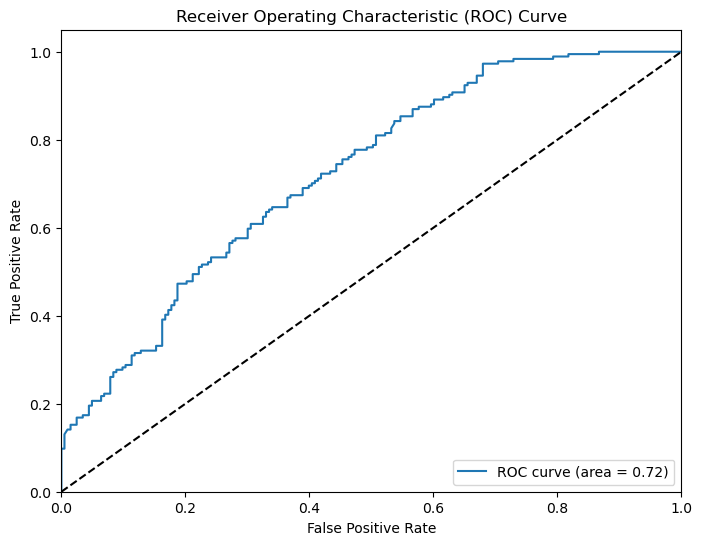

In [109]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


In [131]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu',  input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(len(train_generator.class_indices), activation='sigmoid'))  # Use 1 unit and 'sigmoid' activation for binary classification


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 240s 2s/step - loss: 4.7950 - accuracy: 0.5525 - val_loss: 0.6405 - val_accuracy: 0.6072
Epoch 2/15
97/97 [==============================] - 202s 2s/step - loss: 0.6511 - accuracy: 0.6253 - val_loss: 0.6721 - val_accuracy: 0.5581
Epoch 3/15
97/97 [==============================] - 195s 2s/step - loss: 0.6338 - accuracy: 0.6499 - val_loss: 0.6125 - val_accuracy: 0.6641
Epoch 4/15
97/97 [==============================] - 194s 2s/step - loss: 0.6171 - accuracy: 0.6751 - val_loss: 0.5862 - val_accuracy: 0.6796
Epoch 5/15
97/97 [==============================] - 195s 2s/step - loss: 0.5928 - accuracy: 0.6922 - val_loss: 0.6057 - val_accuracy: 0.6873
Epoch 6/15
97/97 [==============================] - 193s 2s/step - loss: 0.5788 - accuracy: 0.7168 - val_loss: 0.6153 - val_accuracy: 0.7080
Epoch 7/15
97/97 [==============================] - 193s 2s/step - loss: 0.5510 - accuracy: 0.7388 - val_loss: 0.5614 - val_accuracy: 0.7209
Epoch 8/15
97

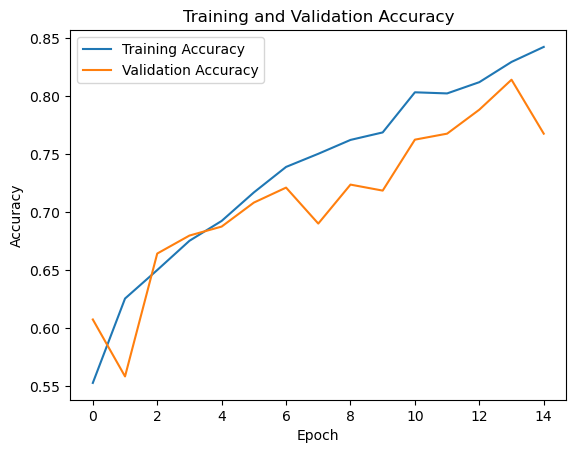

In [132]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 196ms/step
Accuracy: 0.7596899224806202
AUC: 0.8359391732705076
Precision: 0.7486338797814208
Recall: 0.7445652173913043
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                1
1              Palm\anemic\Anemic-267 (3).png           0                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                1
4            Palm\anemic\AnemicP-083 (12).png           0                0
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           0                0
386         

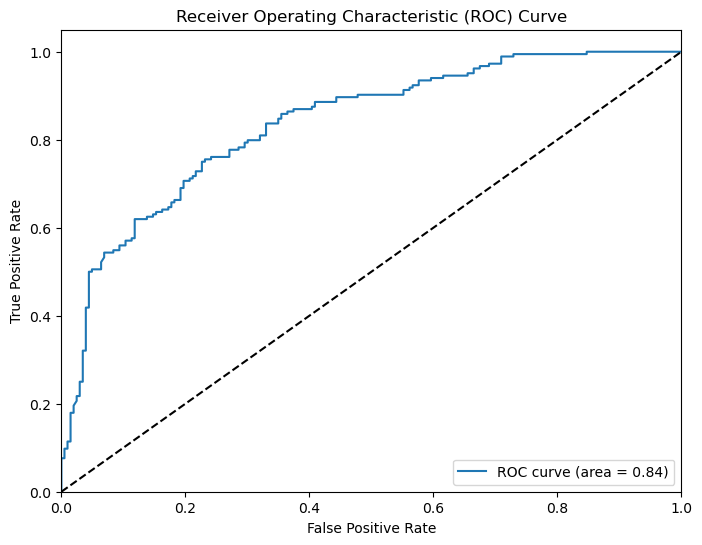

In [133]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)


# VGG16

In [10]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)




Epoch 1/13


97/97 [==============================] - 711s 7s/step - loss: 0.7464 - accuracy: 0.5917 - val_loss: 0.5608 - val_accuracy: 0.7339
Epoch 2/13
97/97 [==============================] - 646s 7s/step - loss: 0.6132 - accuracy: 0.6680 - val_loss: 0.6136 - val_accuracy: 0.6460
Epoch 3/13
97/97 [==============================] - 572s 6s/step - loss: 0.5341 - accuracy: 0.7255 - val_loss: 0.4972 - val_accuracy: 0.7571
Epoch 4/13
97/97 [==============================] - 569s 6s/step - loss: 0.5213 - accuracy: 0.7329 - val_loss: 0.4857 - val_accuracy: 0.7700
Epoch 5/13
97/97 [==============================] - 573s 6s/step - loss: 0.4803 - accuracy: 0.7672 - val_loss: 0.4575 - val_accuracy: 0.7726
Epoch 6/13
97/97 [==============================] - 662s 7s/step - loss: 0.4652 - accuracy: 0.7695 - val_loss: 0.5500 - val_accuracy: 0.7183
Epoch 7/13
97/97 [==============================] - 698s 7s/step - loss: 0.4524 - accuracy: 0.7898 - val_loss: 0.4465 - val_accuracy: 0.7726
Epoch 8/1

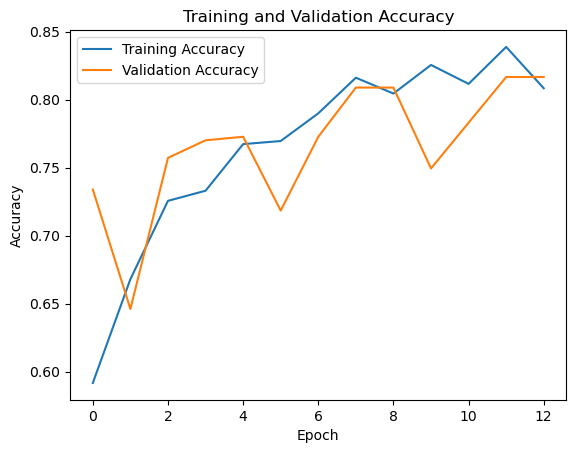

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 745ms/step
Accuracy: 0.7803617571059431
AUC: 0.9044495609338188
Precision: 0.9459459459459459
Recall: 0.5706521739130435
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                0
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                0
4            Palm\anemic\AnemicP-083 (12).png           0                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                0
386         

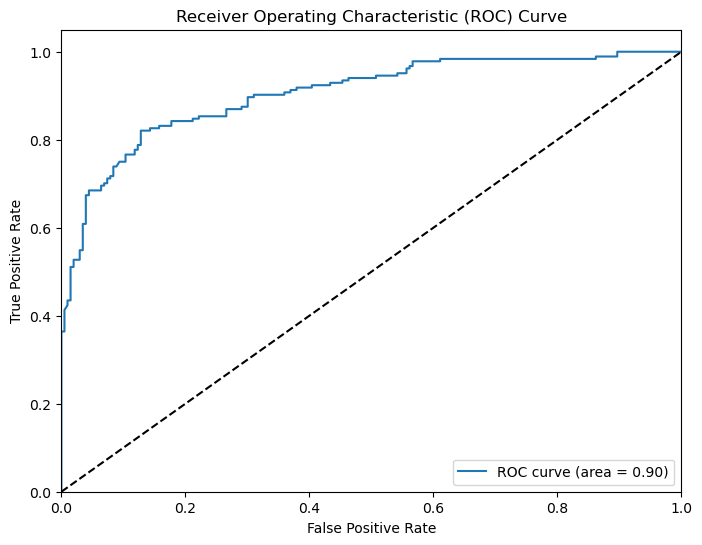

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [13]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=13,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/13
97/97 [==============================] - 578s 6s/step - loss: 0.7396 - accuracy: 0.5978 - val_loss: 0.6701 - val_accuracy: 0.6072
Epoch 2/13
97/97 [==============================] - 570s 6s/step - loss: 0.6277 - accuracy: 0.6631 - val_loss: 0.5872 - val_accuracy: 0.7261
Epoch 3/13
97/97 [==============================] - 669s 7s/step - loss: 0.5704 - accuracy: 0.7093 - val_loss: 0.5468 - val_accuracy: 0.7183
Epoch 4/13
97/97 [==============================] - 579s 6s/step - loss: 0.5397 - accuracy: 0.7313 - val_loss: 0.5711 - val_accuracy: 0.6848
Epoch 5/13
97/97 [==============================] - 569s 6s/step - loss: 0.4868 - accuracy: 0.7620 - val_loss: 0.4808 - val_accuracy: 0.7804
Epoch 6/13
97/97 [==============================] - 578s 6s/step - loss: 0.4701 - accuracy: 0.7753 - val_loss: 0.4765 - val_accuracy: 0.7468
Epoch 7/13
97/97 [==============================] - 570s 6s/step - loss: 0.4478 - accuracy: 0.7763 - val_loss: 0.4966 - val_accuracy: 0.7545
Epoch 8/13
97

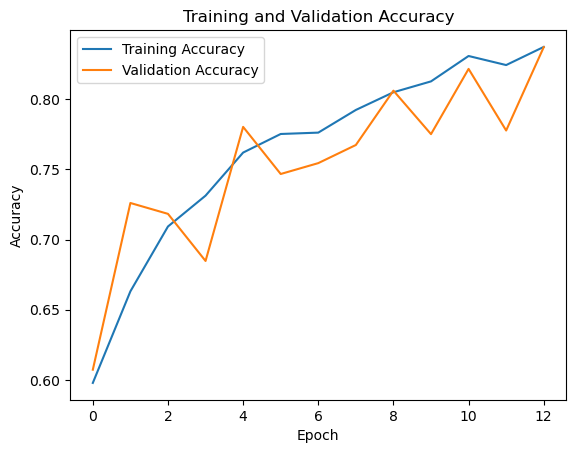

In [14]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 682ms/step
Accuracy: 0.8165374677002584
AUC: 0.9079835082458771
Precision: 0.9185185185185185
Recall: 0.6739130434782609
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                0
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                0
4            Palm\anemic\AnemicP-083 (12).png           0                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                0
386         

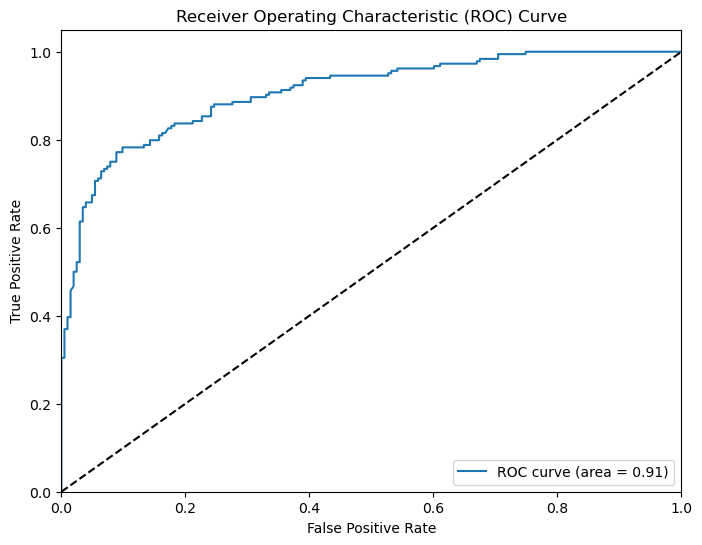

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [16]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  # VGG16 expects input images of size 224x224

# Load VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
97/97 [==============================] - 569s 6s/step - loss: 0.7306 - accuracy: 0.5765 - val_loss: 0.6466 - val_accuracy: 0.6279
Epoch 2/25
97/97 [==============================] - 568s 6s/step - loss: 0.6389 - accuracy: 0.6369 - val_loss: 0.6031 - val_accuracy: 0.6796
Epoch 3/25
97/97 [==============================] - 570s 6s/step - loss: 0.5979 - accuracy: 0.6838 - val_loss: 0.5915 - val_accuracy: 0.6848
Epoch 4/25
97/97 [==============================] - 572s 6s/step - loss: 0.5803 - accuracy: 0.6877 - val_loss: 0.5552 - val_accuracy: 0.6977
Epoch 5/25
97/97 [==============================] - 567s 6s/step - loss: 0.5401 - accuracy: 0.7262 - val_loss: 0.5356 - val_accuracy: 0.7235
Epoch 6/25
97/97 [==============================] - 567s 6s/step - loss: 0.5092 - accuracy: 0.7472 - val_loss: 0.5073 - val_accuracy: 0.7571
Epoch 7/25
97/97 [==============================] - 575s 6s/step - loss: 0.4878 - accuracy: 0.7640 - val_loss: 0.4777 - val_accuracy: 0.7700
Epoch 8/25
97

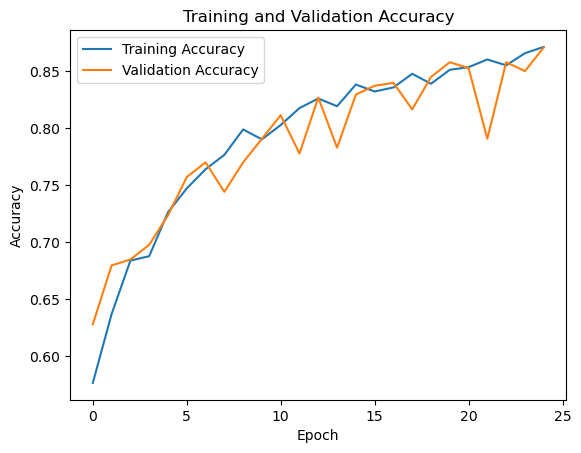

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 634ms/step
Accuracy: 0.8527131782945736
AUC: 0.9227886056971515
Precision: 0.9150326797385621
Recall: 0.7608695652173914
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           0                0
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           1                1
3      Palm\nonanemic\Non-AnemicP-034 (3).png           0                0
4            Palm\anemic\AnemicP-083 (12).png           0                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           1                1
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           0                0
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                0
386         

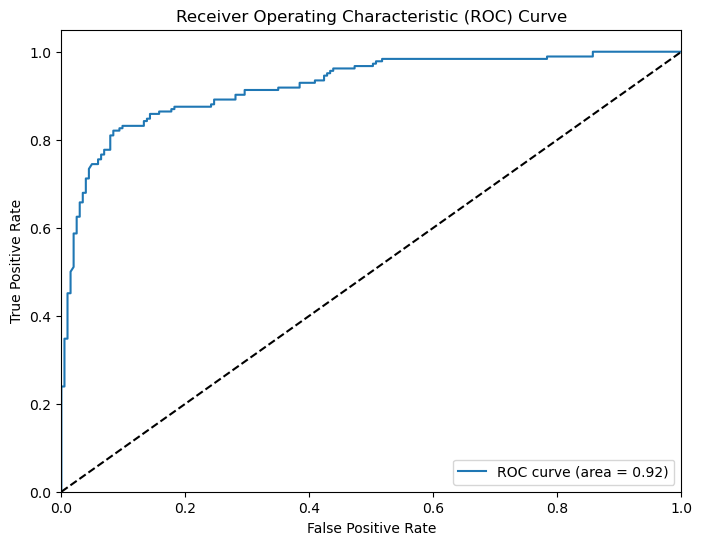

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

# InceptionV3

In [51]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/25
97/97 [==============================] - 159s 2s/step - loss: 1.1705 - accuracy: 0.5134 - val_loss: 0.6647 - val_accuracy: 0.5969
Epoch 2/25
97/97 [==============================] - 151s 2s/step - loss: 0.6708 - accuracy: 0.5609 - val_loss: 0.6476 - val_accuracy: 0.5969
Epoch 3/25
97/97 [==============================] - 143s 1s/step - loss: 0.6032 - accuracy: 0.6440 - val_loss: 0.5657 - val_accuracy: 0.7442
Epoch 4/25
97/97 [==============================] - 150s 2s/step - loss: 0.5127 - accuracy: 0.7834 - val_loss: 0.5076 - val_accuracy: 0.8062
Epoch 5/25
97/97 [==============================] - 153s 2s/step - loss: 0.4355 - accuracy: 0.8480 - val_loss: 0.4465 - val_accuracy: 0.8475
Epoch 6/25
97/97 [==============================] - 162s 2s/step - loss: 0.4083 - accuracy: 0.8603 - val_loss: 0.4267 - val_accuracy: 0.8243
Epoch 7/25
97/97 [==============================] - 149s 2s/step - loss: 0.3730 - accuracy: 0.8843 - val_loss: 0.4143 - val_accuracy: 0.8501
Epoch 8/25
97

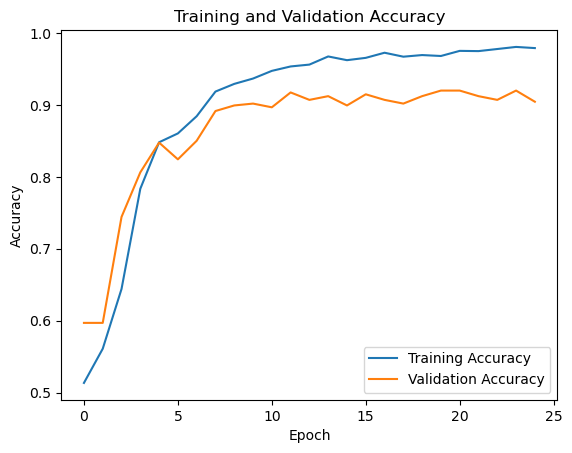

In [52]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step
Accuracy: 0.9147286821705426
AUC: 0.9329620903833796
Precision: 0.8871794871794871
Recall: 0.9402173913043478
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                1
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386            

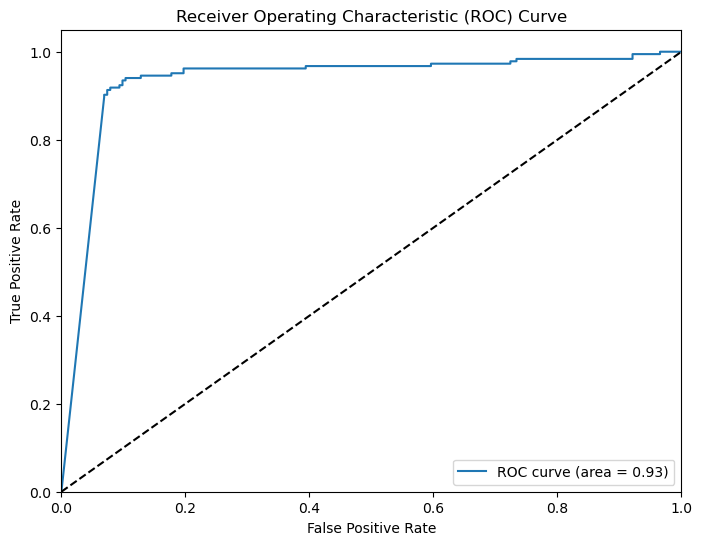

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [54]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 146s 1s/step - loss: 1.3602 - accuracy: 0.5312 - val_loss: 0.6915 - val_accuracy: 0.5969
Epoch 2/15
97/97 [==============================] - 141s 1s/step - loss: 0.6882 - accuracy: 0.5606 - val_loss: 0.6850 - val_accuracy: 0.5969
Epoch 3/15
97/97 [==============================] - 138s 1s/step - loss: 0.6845 - accuracy: 0.5609 - val_loss: 0.6847 - val_accuracy: 0.5969
Epoch 4/15
97/97 [==============================] - 153s 2s/step - loss: 0.6544 - accuracy: 0.5609 - val_loss: 0.6250 - val_accuracy: 0.5969
Epoch 5/15
97/97 [==============================] - 154s 2s/step - loss: 0.5817 - accuracy: 0.5609 - val_loss: 0.5502 - val_accuracy: 0.5969
Epoch 6/15
97/97 [==============================] - 146s 2s/step - loss: 0.5207 - accuracy: 0.7200 - val_loss: 0.5345 - val_accuracy: 0.7494
Epoch 7/15
97/97 [==============================] - 154s 2s/step - loss: 0.4650 - accuracy: 0.8105 - val_loss: 0.4699 - val_accuracy: 0.8191
Epoch 8/15
97

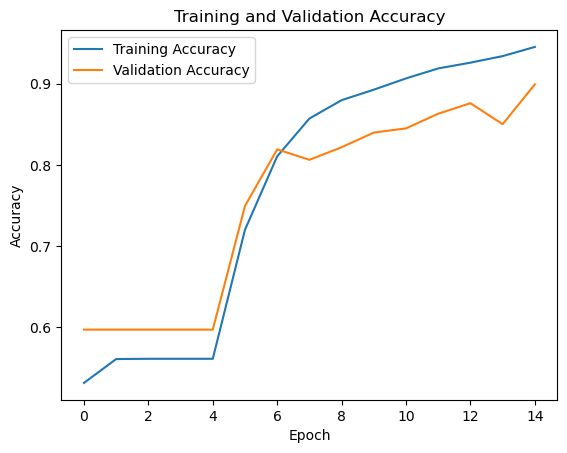

In [55]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
Accuracy: 0.8837209302325582
AUC: 0.9061629899336046
Precision: 0.8601036269430051
Recall: 0.9021739130434783
                                     Filename  True Label  Predicted Label
0            Palm\anemic\AnemicP-063 (12).png           1                1
1              Palm\anemic\Anemic-267 (3).png           1                0
2    Palm\nonanemic\Non-anemic-Pa-015 (6).png           0                0
3      Palm\nonanemic\Non-AnemicP-034 (3).png           1                1
4            Palm\anemic\AnemicP-083 (12).png           1                1
..                                        ...         ...              ...
382           Palm\anemic\Anemic-269 (12).png           0                0
383           Palm\anemic\AnemicP-041 (2).png           1                1
384    Palm\nonanemic\Non-AnemicP-148 (6).png           1                1
385    Palm\nonanemic\Non-AnemicP-067 (5).png           1                1
386            

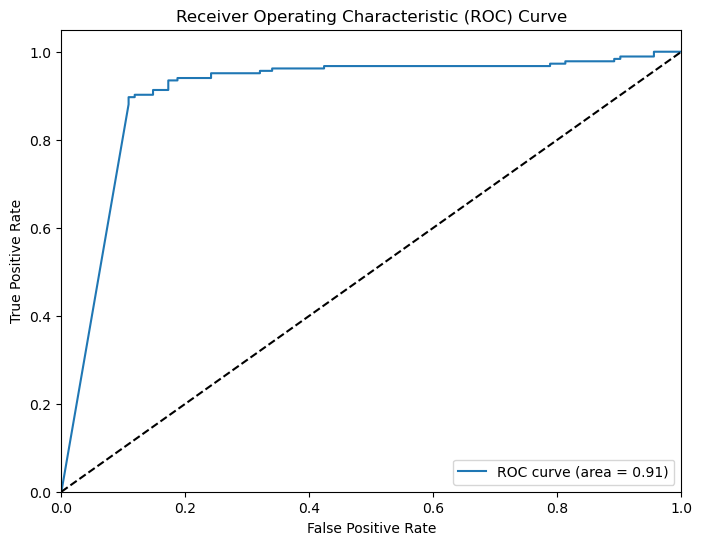

In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

In [15]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3  # Import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define input dimensions
img_height, img_width = 224, 224  

# Load InceptionV3 base model (pre-trained on ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create and compile the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
97/97 [==============================] - 176s 2s/step - loss: 1.1021 - accuracy: 0.6783 - val_loss: 0.4921 - val_accuracy: 0.7752
Epoch 2/15
97/97 [==============================] - 150s 2s/step - loss: 0.3690 - accuracy: 0.8396 - val_loss: 0.5556 - val_accuracy: 0.7209
Epoch 3/15
97/97 [==============================] - 147s 2s/step - loss: 0.2610 - accuracy: 0.8949 - val_loss: 0.3527 - val_accuracy: 0.8605
Epoch 4/15
97/97 [==============================] - 128s 1s/step - loss: 0.1898 - accuracy: 0.9305 - val_loss: 0.3276 - val_accuracy: 0.8630
Epoch 5/15
97/97 [==============================] - 129s 1s/step - loss: 0.1640 - accuracy: 0.9405 - val_loss: 0.3327 - val_accuracy: 0.8786
Epoch 6/15
97/97 [==============================] - 127s 1s/step - loss: 0.1410 - accuracy: 0.9454 - val_loss: 0.2903 - val_accuracy: 0.9121
Epoch 7/15
97/97 [==============================] - 128s 1s/step - loss: 0.1171 - accuracy: 0.9589 - val_loss: 0.2904 - val_accuracy: 0.8966
Epoch 8/15
97

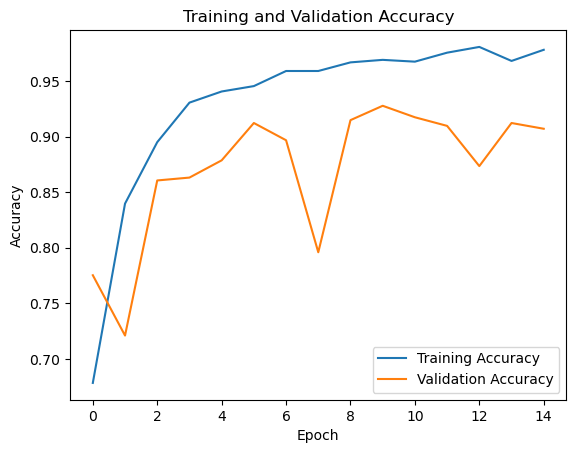

In [16]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
Accuracy: 0.9147286821705426
AUC: 0.9549421717712573
Precision: 0.9171270718232044
Recall: 0.9021739130434783
Confusion Matrix:
[[188  15]
 [ 18 166]]


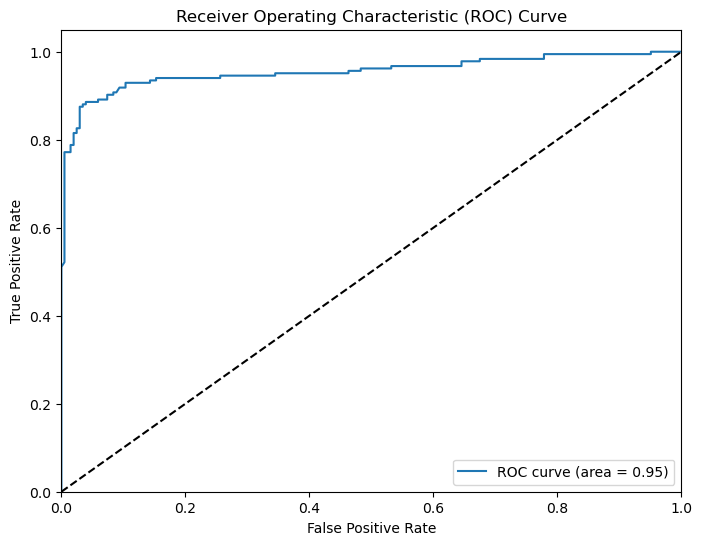

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def predict_test_data(test_generator):
    predictions = []
    true_labels = []
    filenames = []
    probabilities = []  # Store probabilities for computing AUC
    
    # Loop through the test generator and make predictions
    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        batch_predictions = model.predict(batch_images)
        
        # Convert predictions to class labels
        batch_predicted_labels = [np.argmax(prediction) for prediction in batch_predictions]
        predictions.extend(batch_predicted_labels)
        
        # Get true labels
        true_labels.extend([np.argmax(label) for label in batch_labels])
        
        # Get filenames
        filenames.extend(test_generator.filenames[i * test_generator.batch_size:(i + 1) * test_generator.batch_size])
        
        # Store probabilities
        probabilities.extend(batch_predictions)
    
    # Convert probabilities to NumPy array
    probabilities = np.array(probabilities)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)
    
    # Calculate AUC
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Assuming you have 2 classes
    print("AUC:", auc)
    
    # Calculate precision and recall
    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)
    
    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Apply the function to the test generator
predict_test_data(test_generator)

# Model Deployment

In [ ]:
#model deployment

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Define image dimensions
img_height = 224
img_width = 224

# Load your image data using ImageDataGenerator
# Assuming you have 'train_dir' and 'validation_dir' directories containing your image data
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Create validation data generator
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='File_Path',
    y_col='Target',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Create and compile the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make a prediction on one image
from tensorflow.keras.preprocessing import image

# Load the image
img_path = 'Anemic-265 (4).png'  # Replace 'path_to_your_image.jpg' with the actual path to your image
img = image.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Make the prediction
prediction = model.predict(img_array)

# Print the prediction
print("Prediction:", prediction)

# Assuming the classes are encoded as [0, 1] where 0 represents non-anemic and 1 represents anemic
class_names = ['Anemic', 'Non-anemic']

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

# Get the corresponding class label
predicted_class = class_names[predicted_class_index]

# Print the prediction
print("Prediction:", predicted_class)

